# Set Up
### Install and import the stock market API Yahoo Finance

In [ ]:
%pip install yfinance
import yfinance as yf

### Import some librairies

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Get data
### Get EURUSD history

In [5]:
eurusd = yf.Ticker('EURUSD=X')
df = eurusd.history(period='1d', start='2010-1-1', end='2020-1-1')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-12-31,1.4342,1.4439,1.4310,1.4327,0,0,0
2010-01-01,1.4327,1.4402,1.4327,1.4390,0,0,0
2010-01-04,1.4310,1.4452,1.4262,1.4424,0,0,0
2010-01-05,1.4427,1.4483,1.4352,1.4366,0,0,0
2010-01-06,1.4366,1.4435,1.4291,1.4404,0,0,0
...,...,...,...,...,...,...,...
2019-12-25,1.1091,1.1109,1.1078,1.1090,0,0,0
2019-12-26,1.1095,1.1105,1.1083,1.1095,0,0,0
2019-12-27,1.1101,1.1181,1.1100,1.1101,0,0,0


### Plot EURUSD closing price history

Text(0, 0.5, 'Closing price USD')

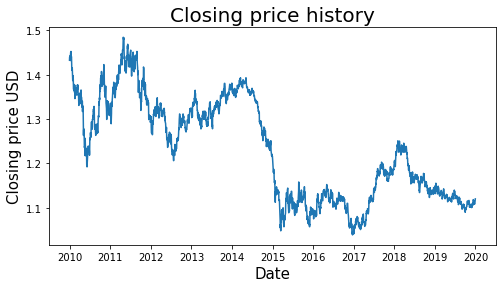

In [7]:
plt.figure(figsize=(8,4))
plt.title('Closing price history', fontsize=20)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Closing price USD', fontsize=15)

# Preprocess the data
### Get our time series

In [8]:
series_v = df['Close'].values
series = series_v[1:]-series_v[:-1]
series_v.shape, series.shape

((2604,), (2603,))

### Split the data to create train and test datasets

In [9]:
split_time = math.ceil(series.shape[0]*0.8)
train_series = series[:split_time]
test_series = series_v[split_time:]
train_series.shape, test_series.shape

((2083,), (521,))

### Normalize data

In [10]:
scaler = MinMaxScaler()
train_series = train_series.reshape((train_series.shape[0], 1))
train_series = scaler.fit_transform(train_series)
series = series.reshape((series.shape[0], 1))
series = scaler.transform(series)
train_series.shape, test_series.shape, series.shape

((2083, 1), (521,), (2603, 1))

In [11]:
def create_dataset(series, window_size=10, batch_size=32):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(series.shape[0])
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  return ds.batch(batch_size).prefetch(1)

# Build the model
### Build the model and find out the best learning rate

In [12]:
train_ds = create_dataset(train_series, window_size=32, batch_size=128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in [1, 2, 4, 8, 16]:
  model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1, padding='causal', dilation_rate=dilation_rate, activation='relu'))
model.add(tf.keras.layers.Conv1D(1, kernel_size=1))

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/30))
history = model.fit(train_ds, epochs=100, callbacks=lr_scheduler, verbose=0)

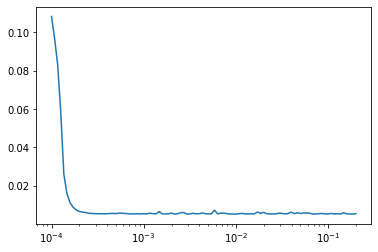

In [13]:
plt.semilogx(history.history['lr'], history.history['loss'])

### Build and train the model

In [14]:
train_ds = create_dataset(train_series, window_size=32, batch_size=128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in [1, 2, 4, 8, 16]:
  model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1, padding='causal', dilation_rate=dilation_rate, activation='relu'))
model.add(tf.keras.layers.Conv1D(1, kernel_size=1))

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['mae'])

save_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_checkpoint.h5', monitor='loss', save_best_only=True)
history = model.fit(train_ds, epochs=50, callbacks=[save_checkpoint], verbose=0)

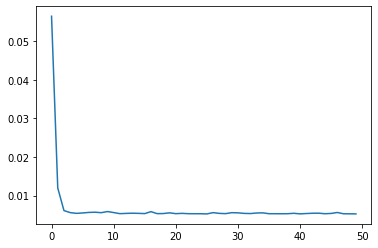

In [15]:
plt.plot(history.history['loss'])

# Use the model to forecast

In [ ]:
model = tf.keras.models.load_model('best_checkpoint.h5')
def create_forecast_dataset(series, window_size=10, batch_size=32):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  return ds.batch(batch_size)

window_size = 32
forecast_ds = create_forecast_dataset(series, window_size=window_size, batch_size=128)
forecast = model.predict(forecast_ds)
forecast = forecast[split_time-window_size:, -1]

In [ ]:
forecast = scaler.inverse_transform(forecast)
forecast = forecast.reshape((forecast.shape[0]))
forecast = forecast + series_v[split_time-1:-1]
plt.figure(figsize=(8, 5))
plt.plot(test_series, c='b', label='stock prices', linewidth=1.0)
plt.plot(forecast, c='orange', label='predicted stock prices', linewidth=1.0)
plt.legend()

# Compute the error rate

In [ ]:
tf.keras.metrics.mean_absolute_percentage_error(forecast, test_series).numpy()